River's model yay

# Data Preprocessing

Using tensorflow to split the dataset into training and test data as well as resizing and normalizing images. 

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

# Define the dataset directory and parameters
data_dir = "./spectrograms"  # dataset path?
batch_size = 32
img_size = (128, 128)  # Resize all images to 128x128

# Load datasets
train_ds = image_dataset_from_directory(
    data_dir,
    validation_split=0.2,  # 20% for validation
    subset="training",
    seed=123,  # Ensure reproducibility
    image_size=img_size,
    batch_size=batch_size
)

val_ds = image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=img_size,
    batch_size=batch_size
)

# Optional: Cache datasets for better performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Normalize images (scale pixel values to [0, 1])
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))


Found 1001 files belonging to 20 classes.
Using 801 files for training.
Found 1001 files belonging to 20 classes.
Using 200 files for validation.


# Build CNN Model

In [4]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Define CNN architecture
def build_cnn(input_shape=(128, 128, 3), num_classes=20):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),

        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),  # Regularization to prevent overfitting
        layers.Dense(num_classes, activation='softmax')  # Output layer
    ])
    return model

# Instantiate the model
num_classes = 20 
model = build_cnn(input_shape=(128, 128, 3), num_classes=num_classes)

# Compile the model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Summary
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 20)             │         2,580 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,307,220 (12.62 MB)

 Trainable params: 3,307,220 (12.62 MB)

 Non-trainable params: 0 (0.00 B)

# Train CNN Model

In [6]:
# Train the model
epochs = 30
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)


Epoch 1/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 135ms/step - accuracy: 0.7835 - loss: 0.6331 - val_accuracy: 0.4200 - val_loss: 3.4431
Epoch 2/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 0.7946 - loss: 0.6008 - val_accuracy: 0.4650 - val_loss: 3.3507
Epoch 3/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 0.8026 - loss: 0.5266 - val_accuracy: 0.4150 - val_loss: 3.6151
Epoch 4/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.8113 - loss: 0.5812 - val_accuracy: 0.4200 - val_loss: 3.7649
Epoch 5/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.8425 - loss: 0.4631 - val_accuracy: 0.3650 - val_loss: 3.9558
Epoch 6/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 141ms/step - accuracy: 0.8317 - loss: 0.4850 - val_accuracy: 0.3850 - val_loss: 4.1042
Epoch 7/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - accuracy: 0.8569 - loss: 0.4447 - val_accuracy: 0.3900 - val_loss: 4.1165
Epoch 8/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 137ms/step - accuracy: 0.8602 - loss: 0.4125 - val_accuracy: 0.

# Evaluating Model

In [ ]:
# Evaluate on the validation set
val_loss, val_acc = model.evaluate(val_ds)
print(f"Validation Accuracy: {val_acc:.2f}")


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.4280 - loss: 4.9764
Validation Accuracy: 0.43


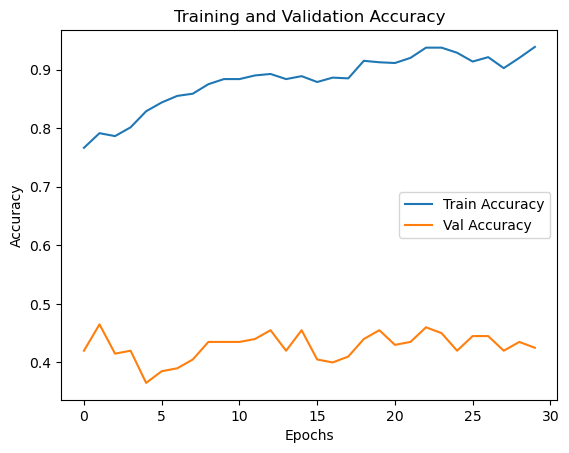

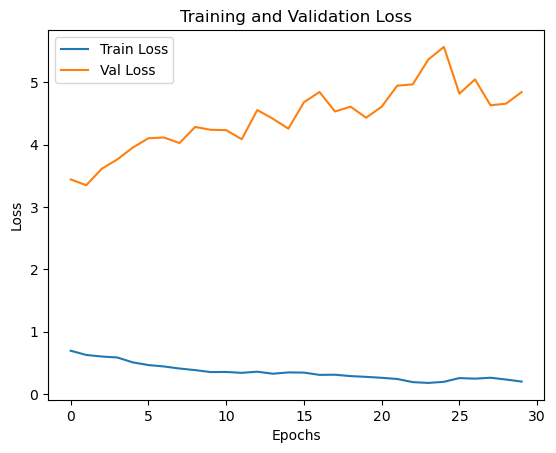

In [9]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.show()
